In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import re
import gc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
        `float64` type to `float32`
        `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Parameters

In [3]:
DATA_PATH = 'E://Kaggle//Avito//'
DATA_IMAGE_PATH = DATA_PATH + 'images//'

In [4]:
seed = 32
VALID = True #Whether or not the notebook should run a validation
n_components_title = 25 #best between 20 and 30
colnames_svdtitle = ['svd_title_'+str(x) for x in range(n_components_title)]

n_components_params = 15 #test best
colnames_svdparams = ['svd_params_'+str(x) for x in range(n_components_params)]

n_components_desc = 45 #best between 35 and 50
colnames_svddesc = ['svd_desc_'+str(x) for x in range(n_components_desc)]

REMOVE_MISSING_DESC = False

Average RMSE 0.22093520452589313 Title comps 15 Desc comps 25

Average RMSE 0.22073878443432582 Title comps 30 Desc comps 50

Average RMSE 0.2207910681589925 Title comps 45 Desc comps 75

Average RMSE 0.22072564018222374 Title comps 60 Desc comps 100

## Load data
complete_data is a concatenate of both dataset + some translations

In [5]:
train = pd.read_csv(DATA_PATH+'train.csv')
test = pd.read_csv(DATA_PATH+'test.csv')
complete_data = pd.concat([train,test],axis=0,ignore_index=True)

In [6]:
complete_data.head(10)

,activation_date,category_name,city,deal_probability,description,image,image_top_1,item_id,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,user_id,user_type
0,2017-03-28,Товары для детей и игрушки,Екатеринбург,0.12789,"Кокон для сна малыша,пользовались меньше месяц...",d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,b912c3c6a6ad,2,Постельные принадлежности,NaN,NaN,Личные вещи,400.0,Свердловская область,Кокоби(кокон для сна),e00f8ff2eaf9,Private
1,2017-03-26,Мебель и интерьер,Самара,0.00000,"Стойка для одежды, под вешалки. С бутика.",79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,2dac0150717d,19,Другое,NaN,NaN,Для дома и дачи,3000.0,Самарская область,Стойка для Одежды,39aeb48f0017,Private
2,2017-03-20,Аудио и видео,Ростов-на-Дону,0.43177,"В хорошем состоянии, домашний кинотеатр с blu ...",b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,ba83aefab5dc,9,"Видео, DVD и Blu-ray плееры",NaN,NaN,Бытовая электроника,4000.0,Ростовская область,Philips bluray,91e2f88dd6e3,Private
3,2017-03-25,Товары для детей и игрушки,Набережные Челны,0.80323,Продам кресло от0-25кг,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,02996f1dd2ea,286,Автомобильные кресла,NaN,NaN,Личные вещи,2200.0,Татарстан,Автокресло,bf5cccea572d,Company
4,2017-03-16,Автомобили,Волгоград,0.20797,Все вопросы по телефону.,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,7c90be56d2ab,3,С пробегом,ВАЗ (LADA),2110,Транспорт,40000.0,Волгоградская область,"ВАЗ 2110, 2003",ef50846afc0b,Private
5,2017-03-28,Товары для детей и игрушки,Чистополь,0.80323,В хорошем состоянии,eb6ad1231c59d3dc7e4020e724ffe8e4d302023ddcbb99...,796.0,51e0962387f7,9,Автомобильные кресла,NaN,NaN,Личные вещи,1300.0,Татарстан,Авто люлька,bbfad0b1ad0a,Private
6,2017-03-23,Ремонт и строительство,Нижний Новгород,0.00000,Электро водонагреватель накопительный на 100 л...,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,2823.0,c4f260a2b48a,125,Сантехника и сауна,NaN,NaN,Для дома и дачи,11000.0,Нижегородская область,Водонагреватель 100 литров нержавейка плоский,08f469d2e6f7,Private
7,2017-03-25,"Одежда, обувь, аксессуары",Пермь,0.80323,Бойфренды в хорошем состоянии.,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,567.0,6b71309d6a8a,61,Женская одежда,Джинсы,26,Личные вещи,500.0,Пермский край,Бойфренды colins,fef86baa002c,Private
8,2017-03-17,"Одежда, обувь, аксессуары",Оренбург,0.00000,54 раз мер очень удобное,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,415.0,c5b969cb63a2,85,Женская одежда,Платья и юбки,> 50 (XXL),Личные вещи,500.0,Оренбургская область,Платье,055825270190,Private
9,2017-03-22,Детская одежда и обувь,Нижний Новгород,0.00000,По стельке 15.5см мерить приокский район. Цвет...,54fb8521135fda77a860bfd2fac6bf46867ab7c06796e3...,46.0,b1570962e68c,136,Для девочек,Обувь,25,Личные вещи,400.0,Нижегородская область,Полу ботиночки замш натур.Бамбини,f9e8f831d94c,Company


# Feature Engineering
#### Relative to Date

Weekday and day could be usefull. I won't add month and week because there is just a minuscule overlap in month and none in weeks. Can be tested if month / day provide any gain in RMSE.

In [7]:
complete_data['activation_date']=pd.to_datetime(complete_data['activation_date'])
complete_data['activation_weekday']=complete_data['activation_date'].dt.weekday
complete_data['activation_day']=complete_data['activation_date'].dt.day #Remove 
complete_data['activation_week']=complete_data['activation_date'].dt.week #Remove 
#complete_data['activation_month']=complete_data['activation_date'].dt.month #Remove

#### Relative to users

In [8]:
complete_data['user_counts']=complete_data.groupby(['user_id'])['item_id'].transform('count')
complete_data['user_counts_bin']=pd.qcut(complete_data['user_counts'],5,duplicates='drop',labels=range(4)) #one duplicate

In [ ]:
item_count_cutoff = 31
common_users = set(train['user_id']).intersection(set(test['user_id']))
temp = train.groupby(['user_id'],as_index=False).agg({'item_id':'count'}).rename(columns={'item_id':'count_item'})
big_users = set(temp[temp['count_item']>=item_count_cutoff]['user_id'])

complete_data['user_id'] = np.where(complete_data['user_id'].isin(common_users),
                                    np.where(complete_data['user_id'].isin(big_users),
                                             complete_data['user_id'],'SmallUser'),'NotCommonUser') #This is why an embedding of the user is useful

User ids that are not in test should not be used. It would create overfitting. Therefore let's clean the user_id by keeping only users that have a minimal presence in test and train. 
To Do : Try to remove users with less than 2 items in train set

This reduces the amount of level of the user_id as a category by a factor 10.

#### Relative to regions
Can use embedding since all region are in both data (need special KFold scheme)

#### Relative to cities

In [10]:
complete_data['city_counts']=complete_data.groupby(['city'])['item_id'].transform('count')
complete_data['city_counts_bin']=pd.qcut(complete_data['city_counts'],5,duplicates='drop',labels=range(5))

In [ ]:
common_cities = set(train['city']).intersection(set(test['city']))
temp = train.groupby(['city'],as_index=False).agg({'item_id':'count'}).rename(columns={'item_id':'count_item'})
big_cities = set(temp[temp['count_item']>=item_count_cutoff]['city'])

complete_data['city'] = np.where(complete_data['city'].isin(common_cities),
                                  np.where(complete_data['city'].isin(big_cities),
                                           complete_data['city'],'SmallCity'),'NotCommonCity')

#### Relative to parent category
Can use embeddings (need special KFold scheme)

#### Relative to category
Can use embeddings (need special KFold scheme)

#### Relative to price

In [11]:
complete_data['log_price']=np.log(1+complete_data['price'])

In [12]:
complete_data['price'].fillna(-999,inplace=True)
complete_data['log_price'].fillna(-999,inplace=True)

In [13]:
complete_data['price_10']=np.where(complete_data['price']>0, (complete_data['price'].astype(int)//10).astype(str).apply(lambda x: x[-1]),-999)
complete_data['price_100']=np.where(complete_data['price']>0, (complete_data['price'].astype(int)//100).astype(str).apply(lambda x: x[-1]),-999)
complete_data['price_1000']=np.where(complete_data['price']>0, (complete_data['price'].astype(int)//1000).astype(str).apply(lambda x: x[-1]),-999)
complete_data['price_10000']=np.where(complete_data['price']>0, (complete_data['price'].astype(int)//10000).astype(str).apply(lambda x: x[-1]),-999)
complete_data['price_100000']=np.where(complete_data['price']>0, (complete_data['price'].astype(int)//100000).astype(str).apply(lambda x: x[-1]),-999)

#### Relative to item_seq_number

In [14]:
complete_data['log_item_seq']=np.log(1+complete_data['item_seq_number'])

#### Relative to user_type
Can use embeddings (need special KFold scheme)

#### Relative to image_top_1

In [15]:
complete_data['image_top_1'].fillna(-999,inplace=True)
train['image_top_1'].fillna(-999,inplace=True)
test['image_top_1'].fillna(-999,inplace=True)
new_image_top = set(test['image_top_1'])-set(train['image_top_1'])
complete_data['image_top_1']=np.where(complete_data['image_top_1'].isin(new_image_top),
                                      -999,complete_data['image_top_1']) #should actually select the closest image class

In [16]:
#Use train only
heatmatrix = pd.crosstab(train['image_top_1'],train['category_name'])
rows = heatmatrix.index
columns = heatmatrix.columns
heatmatrix = heatmatrix.values / np.sum(heatmatrix.values,axis=1,keepdims=True) #Normalize
heatmatrix = pd.DataFrame(heatmatrix,index=rows,columns=columns)
values = []
for image_top_1 in heatmatrix.index:
    for category in heatmatrix.columns:
        values.append([image_top_1,category,heatmatrix.loc[image_top_1,category]])
matrix_long = pd.DataFrame(values,columns=['image_top_1','category_name','heatmatrix_value'])
complete_data = complete_data.merge(matrix_long,how='left',on=['image_top_1','category_name'])
complete_data['heatmatrix_value'].fillna(-999,inplace=True)
#Number of classes in category
class_counts = (heatmatrix>0).sum(axis=0)
class_max = heatmatrix.max(axis=0)
class_mean = heatmatrix.mean(axis=0)
complete_data['class_category_counts'] = complete_data['category_name'].map(class_counts)
complete_data['class_category_max'] = complete_data['category_name'].map(class_max)
complete_data['class_category_mean'] = complete_data['category_name'].map(class_mean)

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


#### Relative to texts

In [17]:
uppercase_regex = re.compile(r'[A-ZА-Я]')
symbols_regex = re.compile(r'[^a-zA-ZА-Я0-9а-я]')
digits_regex = re.compile(r'[0-9]')

In [18]:
complete_data['params'] = complete_data['param_1'].astype(str)+complete_data['param_2'].astype(str)+complete_data['param_3'].astype(str)

In [19]:
wordVectParams = TfidfVectorizer(ngram_range=(1,3),
                                stop_words = stopwords.words('russian')
                               )
params_sparse = wordVectParams.fit_transform(complete_data['params'])

In [21]:
svd_params = TruncatedSVD(n_components=n_components_params)
params_sparse_proj  = svd_params.fit_transform(params_sparse)
complete_data = pd.concat([complete_data,pd.DataFrame(params_sparse_proj,columns=colnames_svdparams)],axis=1)
del params_sparse_proj

In [22]:
#To Do Hyperopt on TFIDF parameters
wordVectTitle = TfidfVectorizer(min_df=2, #Reduce some overfitting (to try in hyper opt)
                                max_df=0.5,
                                ngram_range=(1,3),
                                stop_words = stopwords.words('russian')
                               )
title_sparse = wordVectTitle.fit_transform(complete_data['title'])

In [23]:
svd_title = TruncatedSVD(n_components=n_components_title)
title_sparse_proj  = svd_title.fit_transform(title_sparse)
complete_data = pd.concat([complete_data,pd.DataFrame(title_sparse_proj,columns=colnames_svdtitle)],axis=1)
del title_sparse_proj

In [24]:
complete_data['title_number_uppercase'] = complete_data['title'].str.count(uppercase_regex)
complete_data['title_number_symbols'] = complete_data['title'].str.count(symbols_regex)
complete_data['title_number_digits'] = complete_data['title'].str.count(digits_regex)
complete_data['title_len_chars']=complete_data['title'].apply(lambda x: len(str(x)))
complete_data['title_len_words']=complete_data['title'].str.split().apply(lambda x: len(str(x)))
complete_data['title_unique'] = complete_data['title'].str.split().apply(lambda x: len(set(str(x))))
complete_data['share_unique_title'] = complete_data['title_unique']/complete_data['title_len_words']

In [25]:
#Do that before filling missings
complete_data['desc_number_uppercase'] = complete_data['description'].str.count(uppercase_regex)
complete_data['desc_number_symbols'] = complete_data['description'].str.count(symbols_regex)
complete_data['desc_number_digits'] = complete_data['description'].str.count(digits_regex) #should do similar stuff for param
complete_data['desc_len_char']=complete_data['description'].apply(lambda x: len(str(x)))
complete_data['desc_len_words']=complete_data['description'].str.split().apply(lambda x: len(str(x)))
complete_data['desc_unique'] = complete_data['description'].str.split().apply(lambda x: len(set(str(x))))
complete_data['share_unique_desc'] = complete_data['desc_unique']/complete_data['desc_len_words']

In [26]:
complete_data['desc_number_uppercase'].fillna(-999,inplace=True)
complete_data['desc_number_symbols'].fillna(-999,inplace=True)
complete_data['desc_number_digits'].fillna(-999,inplace=True)
complete_data['desc_len_char'].fillna(-999,inplace=True)
complete_data['desc_len_words'].fillna(-999,inplace=True)
complete_data['desc_unique'].fillna(-999,inplace=True)
complete_data['share_unique_desc'].fillna(-999,inplace=True)

In [27]:
complete_data['description'].fillna('Missing',inplace=True)
wordVectDesc = TfidfVectorizer(min_df=2,
                                max_df=0.5,
                                ngram_range=(1,2),
                                stop_words = stopwords.words('russian')
                               )
desc_sparse = wordVectDesc.fit_transform(complete_data['description'])

svd_desc = TruncatedSVD(n_components=n_components_desc)
desc_sparse_proj  = svd_desc.fit_transform(desc_sparse)
complete_data = pd.concat([complete_data,pd.DataFrame(desc_sparse_proj,columns=colnames_svddesc)],axis=1)
del desc_sparse_proj

In [28]:
test_title = set(complete_data[complete_data['deal_probability'].isna()]['title'])
train_title = set(complete_data[complete_data['deal_probability'].notnull()]['title'])
title_to_include = test_title.intersection(train_title)
complete_data['title_clean']=np.where(complete_data['title'].isin(title_to_include),complete_data['title'],'Other')

In [29]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011862 entries, 0 to 2011861
Columns: 138 entries, activation_date to title_clean
dtypes: category(2), datetime64[ns](1), float64(98), int64(16), object(21)
memory usage: 2.1+ GB


In [30]:
complete_data = downcast_dtypes(complete_data)

In [31]:
complete_data.to_csv(DATA_PATH+'complete_data_fe_svd.csv',index=False)

## Encode categoricals (Start from here when feature engineering is saved)

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import gc
from time import time

import catboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
        `float64` type to `float32`
        `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [2]:
DATA_PATH = 'E://Kaggle//Avito//'
DATA_IMAGE_PATH = DATA_PATH + 'images//'
seed = 32
VALID = True #Whether or not the notebook should run a validation
n_components_title = 25 #best between 20 and 30
colnames_svdtitle = ['svd_title_'+str(x) for x in range(n_components_title)]

n_components_params = 15 #test best
colnames_svdparams = ['svd_params_'+str(x) for x in range(n_components_params)]

n_components_desc = 40 #best between 35 and 50
colnames_svddesc = ['svd_desc_'+str(x) for x in range(n_components_desc)]

REMOVE_MISSING_DESC = False

In [3]:
complete_data = pd.read_csv(DATA_PATH+'complete_data_fe_svd.csv')

In [4]:
#Fill missings in categorical variables (that will be used)
categoricals_toencode = ['category_name','parent_category_name',
                'city','region',
                'user_id','user_id_clean','user_type',
                'image_top_1',
                'param_1','param_2','param_3','title','title_clean','params']
encoder = LabelEncoder() #Encoder also encodes missings
for cat in categoricals_toencode:
    complete_data[cat] = encoder.fit_transform(complete_data[cat].astype(str))

In [5]:
#Sanity check
complete_data.isnull().sum()

activation_date              0
category_name                0
city                         0
deal_probability        508438
description                  0
image                   155197
image_top_1                  0
item_id                      0
item_seq_number              0
param_1                      0
param_2                      0
param_3                      0
parent_category_name         0
price                        0
region                       0
title                        0
user_id                      0
user_type                    0
activation_weekday           0
activation_day               0
activation_week              0
user_counts                  0
user_counts_bin              0
user_id_clean                0
city_counts                  0
city_counts_bin              0
log_price                    0
price_10                     0
price_100                    0
price_1000                   0
                         ...  
svd_desc_16                  0
svd_desc

In [6]:
complete_data = downcast_dtypes(complete_data)

## Split back

In [7]:
train = complete_data[complete_data['deal_probability'].notnull()].copy()
test = complete_data[complete_data['deal_probability'].isna()].copy()
del complete_data
if REMOVE_MISSING_DESC:
    train = train[train['description']!='Missing']
gc.collect()

46

## Declaring Variables

In [8]:
target = 'deal_probability'

numericals = ['price','log_price','item_seq_number','log_item_seq','user_counts','city_counts']
numericals += ['title_number_uppercase','title_len_chars','title_len_words','title_unique','share_unique_title']+colnames_svdtitle
numericals += ['desc_number_uppercase','desc_len_char','desc_len_words','desc_unique','share_unique_desc']+colnames_svddesc
numericals += colnames_svdparams
numericals += ['heatmatrix_value','class_category_counts','class_category_max','class_category_mean']
numericals += ['price_10','price_100','price_1000','price_10000','price_100000']

categoricals = ['category_name','parent_category_name','city','image_top_1','param_1','param_2','param_3',
                'activation_weekday',
                'region','user_type','user_counts_bin','city_counts_bin',
               'user_id_clean','title_clean','params']
#Removed user_id, title => These cause problems for catboost
features = numericals+categoricals
index_cat = list(range(len(numericals),len(features)))

In [9]:
X = train[features].values
y = train[target].values
X_board = test[features].values

## Feature Importance 
Catboost issue with large GBDT when calculating feature importance

In [10]:
cat_params = {'eval_metric':'RMSE',
              'logging_level':'Silent',
              
              'depth':12,
              'iterations':350,
              'learning_rate':0.2,
              'one_hot_max_size':5,
              
              'used_ram_limit':20*1024*1024*1024,
              'task_type':'GPU'}
cat_model = catboost.CatBoostRegressor(**cat_params)

In [11]:
cat_model.fit(X=X,y=y,verbose=False,cat_features = index_cat)

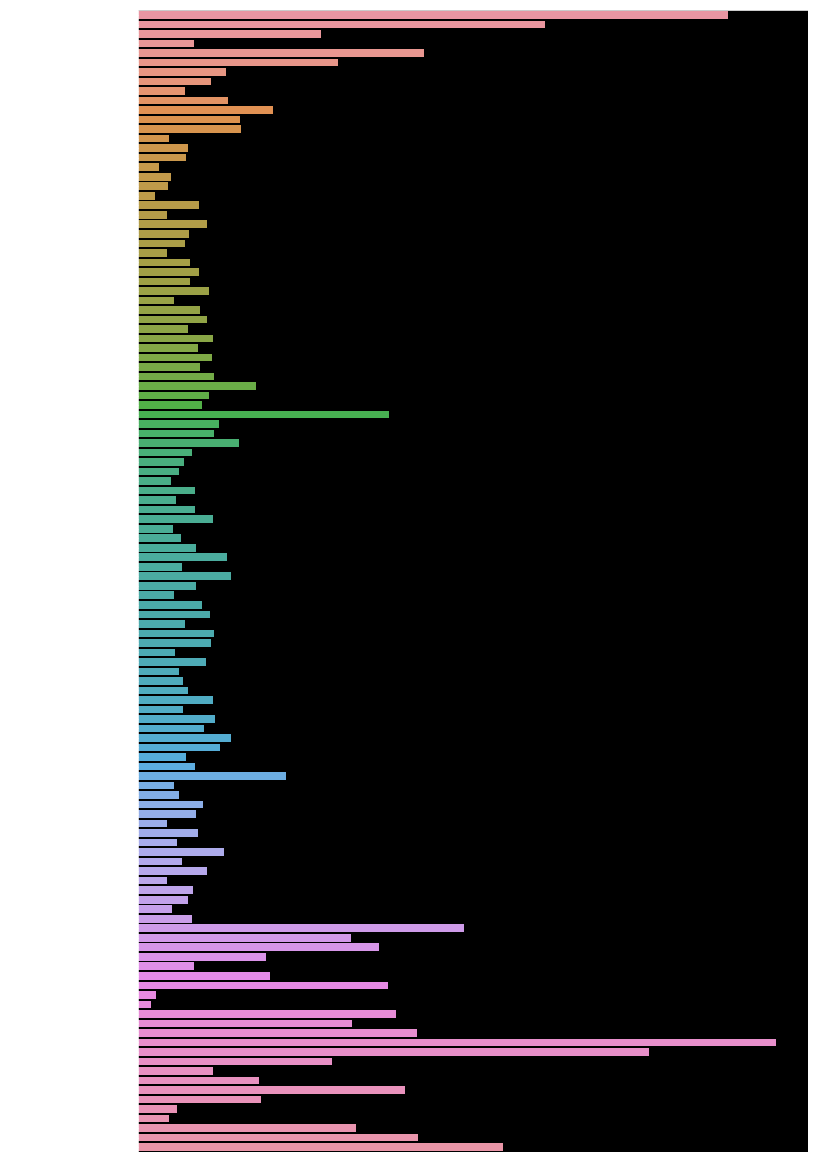

In [12]:
plt.figure(figsize=(12,21))
sns.barplot(x=cat_model.feature_importances_, y=features)
plt.show()

## Model

In [13]:
cat_params = {'eval_metric':'RMSE',
              'logging_level':'Silent',
              
              'depth':12,
              'iterations':1200,
              'learning_rate':0.10,
              'one_hot_max_size':5,
              
              'used_ram_limit':20*1024*1024*1024,
              'gpu_ram_part':0.8,
              'random_seed':seed,
              'task_type':'GPU',
              'od_type':"Iter",
              'calc_feature_importance':False,
              'od_wait':60}
cat_model = catboost.CatBoostRegressor(**cat_params)

## Validation Scheme

In [14]:
kf = KFold(5,shuffle=True,random_state=seed)
sf = ShuffleSplit(3,test_size=0.1)

In [15]:
if VALID:
    i=0
    rmse=[]
    n_trees =[]
    for train_idx, test_idx in kf.split(X,y):
        start = time()
        cat_model.fit(X=X[train_idx],y=y[train_idx],eval_set=(X[test_idx],y[test_idx]),cat_features = index_cat, 
                      verbose=False,use_best_model=True)

        rmse.append(mean_squared_error(y[test_idx],cat_model.predict(X[test_idx]).clip(0.0,1.0))**0.5)
        n_trees.append(cat_model.tree_count_)
        print('Fold',str(i),'RMSE is',rmse[i])
        print(cat_model.tree_count_)
        i+=1
        print((time()-start)//60,'Minutes')

    print('Average RMSE',sum(rmse)/len(rmse))

Fold 0 RMSE is 0.22064287311811812
817
10.0 Minutes
Fold 1 RMSE is 0.22075877905089605
857
10.0 Minutes
Fold 2 RMSE is 0.22043371043337273
935
10.0 Minutes
Fold 3 RMSE is 0.22031545931675806
837
10.0 Minutes
Fold 4 RMSE is 0.22048752232759447
810
10.0 Minutes
Average RMSE 0.22052766884934788


## Predictions

In [16]:
cat_params_predict = cat_params.copy()
#cat_params_predict['calc_feature_importance']=True

if VALID:
    cat_params_predict['iterations']=sum(n_trees)//len(n_trees)
del cat_model
gc.collect()
cat_model = catboost.CatBoostRegressor(**cat_params_predict)
cat_model.fit(X=X,y=y,verbose=False,cat_features = index_cat)

In [17]:
predicted_values = cat_model.predict(X_board)

In [18]:
test['deal_probability']=predicted_values.clip(0.0,1.0)
test[['item_id','deal_probability']].to_csv(DATA_PATH+'Predictions_Cat_Text_svd.csv',index=False)

In [19]:
test['deal_probability']=np.where(test['deal_probability']<=0.95,test['deal_probability'].clip(0,0.9),
                                 1.0)
test[['item_id','deal_probability']].to_csv(DATA_PATH+'Predictions_Cat_Text_svd_romainIdea.csv',index=False)

In [21]:
if VALID:
    i=0
    rmse=[]
    n_trees =[]
    fold_predictions = []
    for train_idx, test_idx in kf.split(X,y):
        start = time()
        cat_model.fit(X=X[train_idx],y=y[train_idx],eval_set=(X[test_idx],y[test_idx]),cat_features = index_cat, 
                      verbose=False,use_best_model=True)

        rmse.append(mean_squared_error(y[test_idx],cat_model.predict(X[test_idx]).clip(0.0,1.0))**0.5)
        n_trees.append(cat_model.tree_count_)
        print('Fold',str(i),'RMSE is',rmse[i])
        print(cat_model.tree_count_)
        i+=1
        print((time()-start)//60,'Minutes')
        
        predicted_values = cat_model.predict(X_board)
        fold_predictions.append(predicted_values.clip(0.0,1.0))
        
    print('Average RMSE',sum(rmse)/len(rmse))
    fold_predictions = np.mean(np.stack(fold_predictions),axis=0)
    test['deal_probability']=fold_predictions
    test[['item_id','deal_probability']].to_csv(DATA_PATH+'Predictions_FOLD_Cat_svd.csv',index=False)

Fold 0 RMSE is 0.2205909934759234
837
7.0 Minutes
Fold 1 RMSE is 0.2206964149997498
804
7.0 Minutes
Fold 2 RMSE is 0.22055450281402728
832
7.0 Minutes
Fold 3 RMSE is 0.22037767058609473
848
7.0 Minutes
Fold 4 RMSE is 0.22048752232759447
810
7.0 Minutes
Average RMSE 0.2205414208406779
